In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, FCC
import numpy as np
import sys
from coffea.analysis_tools import PackedSelection, Cutflow
import awkward as ak
import pandas as pd
import dask_awkward as dak
import hist.dask as hda
from collections import namedtuple
import hist
import fastjet
import vector
vector.register_awkward()
import sys
import os
# local_dir = os.environ['LOCAL_DIR']
local_dir = '/home/prayag/coffeafcc/coffea-fcc-analyses/'
sys.path.append(local_dir)
import scripts
from scripts.analyzers import ReconstructedParticle as ReconstructedParticleUtil
from scripts.analyzers import Jet as JetUtil

plots = {
    'dijet_m':{'name':'dijet_higgs_m','title':'Dijet Higgs Mass','xlabel':'Dijet mass [GeV]','ylabel':'Events','bins':80,'xmin':70,'xmax':150},
    #'pdgid':{'name':'jets_truth','title':'Jets Truth','xlabel':'Jet truth label PDGID','ylabel':'Events','bins':16,'xmin':-8,'xmax':8},
    'recoil':{'name':'zmumu_recoil_m','title':'Recoil from Z (mass)','xlabel':'Recoil [GeV]','ylabel':'Events','bins':200,'xmin':120,'xmax':140},
    'p_ll':{'name':'zmumu_p','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Momentum','xlabel':'$p\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':50,'xmin':20,'xmax':70},
    'm_ll':{'name':'zmumu_m','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Mass','xlabel':'$m\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':40,'xmin':70,'xmax':110},
}
plot_props = pd.DataFrame(plots)

/home/prayag/coffeafcc/development/coffea/src/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
fcc = FCC.get_schema()
events = NanoEventsFactory.from_root(
    '../../data/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root:events',
    schemaclass=fcc,
    # entry_stop=10000,
    metadata={'dataset':'ZH'},
    delayed=True,
    uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
).events()

/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: UserWarning: Skipping _floatMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _floatMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:234: UserWarning: Skipping _floatMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:226: Us

In [3]:
def get_1Dhist(name, var, flatten=False):
    '''
    name: eg. Zm
    var: eg. variable containing array of mass of Z
    flatten: If to flatten var before fill; True by default
    Returns a histogram
    '''
    props = plot_props[name]
    if flatten : var = dak.ravel(var) # Removes None values and all the nesting
    var = var[~dak.is_none(var, axis=0)] # Remove None values only
    return hda.Hist.new.Reg(props.bins, props.xmin, props.xmax).Double().fill(var)

In [4]:
# Object Selections
Muons = events.ReconstructedParticles.match_collection(events.Muonidx0)
sel_muon_p_gt_25 = Muons.p > 25.0
Muons = Muons[sel_muon_p_gt_25]
Z = ReconstructedParticleUtil.resonanceBuilder(Muons, 91.0)
Recoil = ReconstructedParticleUtil.recoilBuilder(Z, 240.0)

#Event Selections
cuts = PackedSelection()
cuts.add("n_gte_2_Muons", ak.num(Muons, axis=1) >= 2 )
cuts.add("m_gt_70_Z", Z.m > 70.0 )
cuts.add("m_lt_100_Z", Z.m < 100.0 )
cuts.add("p_gt_20_Z", Z.p > 20.0 )
cuts.add("p_lt_70_Z", Z.p < 70.0 )
cuts.add("m_gt_120_Recoil", Recoil.m > 120.0 )
cuts.add("m_lt_140_Recoil", Recoil.m < 140.0 )

# Apply the event selections
Good_Z = Z[cuts.all()]
Good_Recoil = Recoil[cuts.all()]

# The remove function removes those matched indices provided as argument 2
# To remove muons with p greater than 25, we have to use that cut on indices
# before passing on to the remove function
high_p_muon_indices = events.Muonidx0[sel_muon_p_gt_25]
rps_no_mu = ReconstructedParticleUtil.remove(events.ReconstructedParticles, high_p_muon_indices)
rps_no_mu = rps_no_mu[cuts.all()] #Apply all the event selections
pseudo_jets = ak.zip(
    {
    'px':rps_no_mu.px,
    'py':rps_no_mu.py,
    'pz':rps_no_mu.pz,
    'E':rps_no_mu.E
    },
    with_name="Momentum4D"
)
arg_sort_pt = ak.argsort(pseudo_jets.pt)
jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
# Requirements:
# [Done] arg_exclusive = 2
# [Not Sure] arg_cut = 2 i.e., N jets for m_exclusive
# [Not Sure] arg_sorted = 0 i.e., p_T ordering
# [Done] arg_recombination = 10 i.e., E0_scheme : Special for FCCAnalyses
jetdef.set_python_recombiner(JetUtil.E0_scheme)
#jetdef.description()
cluster = fastjet.ClusterSequence(pseudo_jets[arg_sort_pt], jetdef)
jet_constituents = cluster.constituents()
jets = cluster.exclusive_jets(2)
dijets = ak.sum(jets, axis=1)

#Prepare output
#Choose the required histograms and their assigned variables to fill
names = plot_props.columns.to_list()
vars_sel = [dijets.m, Good_Recoil.m, Good_Z.p, Good_Z.m, dijets.m]
sel_ocl = cuts.cutflow(*cuts.names).yieldhist()

Output = {
    'histograms': {
        'sel':{name:get_1Dhist(name,var,flatten=False) for name,var in zip(names,vars_sel)},
    },
    'cutflow': {
        'sel': {'Onecut':sel_ocl[0],'Cutflow':sel_ocl[1],'Labels':sel_ocl[2]},
    }
}

In [5]:
Output["histograms"]["sel"]

{'dijet_m': Hist(Regular(80, 70, 150, label='Axis 0'), storage=Double()) # (has staged fills),
 'recoil': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # (has staged fills),
 'p_ll': Hist(Regular(50, 20, 70, label='Axis 0'), storage=Double()) # (has staged fills),
 'm_ll': Hist(Regular(40, 70, 110, label='Axis 0'), storage=Double()) # (has staged fills)}

In [6]:
a = Output["histograms"]["sel"]["dijet_m"].compute()
b = Output["histograms"]["sel"]["recoil"].compute()
c = Output["histograms"]["sel"]["p_ll"].compute()
d = Output["histograms"]["sel"]["m_ll"].compute()

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3765b57e90>, errorbar=None, legend_artist=None)]

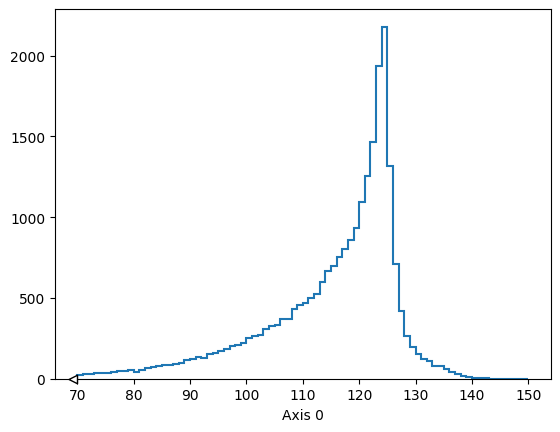

In [7]:
(a*0.3).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0b0bc945c0>, errorbar=None, legend_artist=None)]

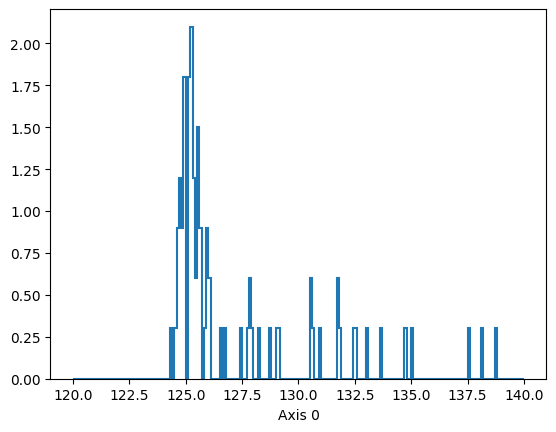

In [8]:
(b*0.3).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0b0971f950>, errorbar=None, legend_artist=None)]

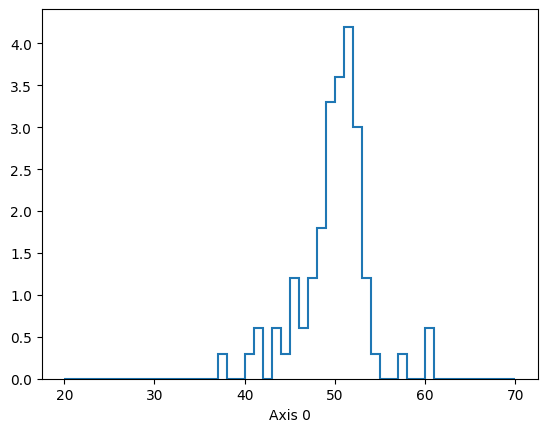

In [9]:
(c*0.3).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0b0aebc8c0>, errorbar=None, legend_artist=None)]

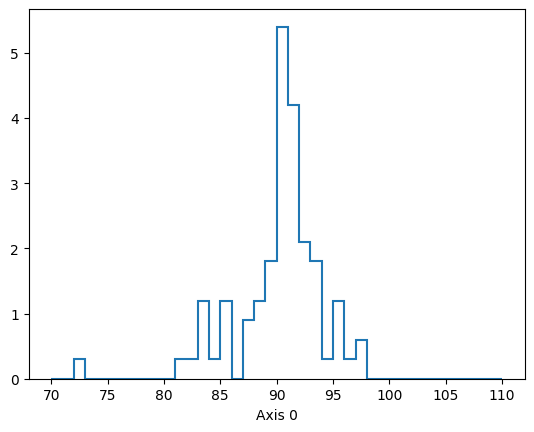

In [10]:
(d*0.3).plot()